# Dataset split

In this notebook, we perform the following operations:

1. Perform train-val-test split on the processed data in data/interim
2. Create setting 1 with all data
3. Create setting 2 with X:1 data with X>1 as the number of elements from label 0 images

In order to perform all these operations it is **required** do to run the previous notebooks by number convention.

In [1]:
import re, shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from loguru import logger
from pathlib import Path
from embryo_project.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, ANNOTATIONS_FILE, FIGURES_DIR
from sklearn.model_selection import train_test_split

2025-08-05 15:05:07.761 | INFO     | embryo_project.config:<module>:11 - PROJ_ROOT path is: C:\Users\Molinari\Desktop\embryo-project


In [2]:
df = pd.read_csv(ANNOTATIONS_FILE, sep='\t')

In [3]:
all_folders = sorted([f for f in INTERIM_DATA_DIR.iterdir() if f.is_dir()])

# For stratification purposes we use folder and label
folder_labels = df.drop_duplicates(subset='folder')[['folder', 'label']]
folder_labels = folder_labels[folder_labels['folder'].isin([f.name for f in all_folders])]

# Stratified split
train_folders, temp_folders = train_test_split(
    folder_labels, test_size=0.30, stratify=folder_labels['label'], random_state=42
)
val_folders, test_folders = train_test_split(
    temp_folders, test_size=0.50, stratify=temp_folders['label'], random_state=42
)

def copy_folders(folders_df, split_name):
    dest_dir = PROCESSED_DATA_DIR / split_name
    dest_dir.mkdir(parents=True, exist_ok=True)

    for _, row in folders_df.iterrows():
        folder_name = row['folder']
        src = INTERIM_DATA_DIR / folder_name
        dst = dest_dir / folder_name
        if dst.exists():
            shutil.rmtree(dst)
        shutil.copytree(src, dst)

copy_folders(train_folders, "train")
copy_folders(val_folders, "val")
copy_folders(test_folders, "test")

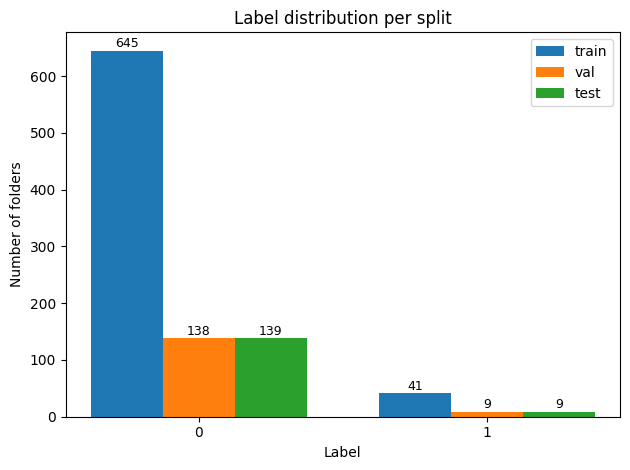

In [4]:
splits = {'train': train_folders, 'val': val_folders, 'test': test_folders}
counts = {}

for name, df_split in splits.items():
    counts[name] = df_split['label'].value_counts().sort_index()

labels = sorted(set(train_folders['label'].unique()) |
                set(val_folders['label'].unique()) |
                set(test_folders['label'].unique()))
x = range(len(labels))

bar_width = 0.25
fig, ax = plt.subplots()

for i, (split_name, count_series) in enumerate(counts.items()):
    y = [count_series.get(label, 0) for label in labels]
    x_shifted = [p + i * bar_width for p in x]
    bars = ax.bar(x_shifted, y, width=bar_width, label=split_name)

    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.5,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

ax.set_xticks([p + bar_width for p in x])
ax.set_xticklabels(labels)
ax.set_xlabel("Label")
ax.set_ylabel("Number of folders")
ax.set_title("Label distribution per split")
ax.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "4a-label-distrivbution-split.png")
plt.show()

In [5]:
df_yes = train_folders[train_folders['label'] == 1]
df_no = train_folders[train_folders['label'] == 0]

n_yes = len(df_yes)
n_no = int(np.floor(n_yes * 1.5))

df_no_sampled = df_no.sample(n=n_no, random_state=42)
balanced_df = pd.concat([df_yes, df_no_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Data distribution:")
print(balanced_df['label'].value_counts())

Data distribution:
label
0    61
1    41
Name: count, dtype: int64


In [6]:
bal_path = PROCESSED_DATA_DIR / "train_balanced"
bal_path.mkdir(parents=True, exist_ok=True)

for folder_name in balanced_df['folder']:
    src_path = INTERIM_DATA_DIR / folder_name
    dst_path = bal_path / folder_name

    if src_path.exists():
        if dst_path.exists():
            shutil.rmtree(dst_path)
        shutil.copytree(src_path, dst_path)
    else:
        logger.warning(f"Source folder {src_path} does not exist")